In [1]:
# initialize stuff
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import logging
import importlib

import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt

from tqdm import tqdm
from time import time
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from itertools import product

%matplotlib inline

In [3]:
# import theory stuff

%reload_ext autoreload
%autoreload 2

HOME_DIR = "/Users/oliver/Documents/p5control-bluefors-evaluation"
sys.path.append(HOME_DIR)

from utilities.corporate_design_colors_v4 import cmap, colors

from theory.models.functions import bin_y_over_x, oversample

from theory.models.constants import G_0_muS
importlib.reload(sys.modules["theory.models.constants"])

loaded constants...


<module 'theory.models.constants' from '/Users/oliver/Documents/p5control-bluefors-evaluation/theory/models/constants.py'>

In [37]:
# Initial guessing parameter
tau_0_arbu: float = 0.18861238619219342
T_0_K: float = 0.3
Delta_0_meV: float = 0.1954362246372233
Gamma_0_meV: float = 0.0073389200475204005

# Data
nu_GHz = 13.6  # n = perfect, slight gap closing
A_mV: NDArray[np.float64] = np.arange(0, 1.55, 0.01, dtype="float64")

V_mV: NDArray[np.float64] = np.linspace(-2.0, 2.0, 801, dtype="float64")
V_off_range_mV: NDArray[np.float64] = np.linspace(-0.045, 0.045, 451, dtype="float64")

I_nA: NDArray[np.float64] = np.linspace(-30, 30, 601, dtype="float64")
I_off_range_nA: NDArray[np.float64] = np.linspace(-0.35, 0.35, 701, dtype="float64")

# exp_data evaluation
sampling_rate: float = 13.7
window_length: int = 0

# interesting Amplitudes
A_lim_mV: tuple[float, float] = (0, 705)  # mV
A_interest_mV: list[float] = [0, 100, 250, 400]  # mV

# PAT parameter
# nu_GHz: float = 7.8  # n = many, gap closing
# nu_GHz: float = 8.0  # n = inf, ever so slight gap closing
# nu_GHz: float = 15.0 # n = 2, crap
# nu_GHz: float = 18.3  # n = okay, slight gap closing
# nu_GHz: float = 19.3 # n = 3, crap

In [ ]:
# Get exp data
from utilities.ivevaluation import IVEvaluation

importlib.reload(sys.modules["utilities.ivevaluation"])
logger = logging.getLogger()
logger.setLevel(level=logging.WARNING)

eva = IVEvaluation()
eva.file_directory = "/Users/oliver/Documents/measurement data/"
eva.file_folder = "25 04 OI-25c-09/"
eva.file_name = "OI-25c-09 2025-05-02 unbroken stripline irradiation studies 0.hdf5"
eva.sub_folder = ""

eva.setAmplifications(1000, 1000)
eva.setV(
    voltage_minimum=np.min(V_mV) * 1e-3,
    voltage_maximum=np.max(V_mV) * 1e-3,
    voltage_bins=V_mV.shape[0] - 1,
)
eva.eva_current = True
eva.setI(
    current_minimum=np.min(I_nA) * 1e-9,
    current_maximum=np.max(I_nA) * 1e-9,
    current_bins=I_nA.shape[0] - 1,
)
eva.eva_voltage = True

eva.downsample_frequency = sampling_rate

eva.title = f"amplitude at {nu_GHz:.1f}GHz"
eva.setMeasurement(f"vna_amplitudes_{nu_GHz:.1f}000GHz")
eva.setKeys(index_0=-6, index_1=-1, norm=1e0, to_pop="no_irradiation")
eva.addKey("no_irradiation", 0)
eva.addKey("no_irradiation", 0.005)
(eva.up_sweep,) = eva.getMaps(
    [1], y_lim=tuple(np.array(A_lim_mV) * 1e-3), skip=(20, None)
)
eva.saveData()

# logger.setLevel(level=logging.INFO)
# eva.showMeasurements()
# eva.showKeys()

# plot and load exp data
%matplotlib inline
from utilities.ivplot import IVPlot
importlib.reload(sys.modules["utilities.ivplot"])
logger = logging.getLogger()
logger.setLevel(level=logging.WARNING)

eva = IVPlot()
eva.title = f"amplitude at {nu_GHz:.1f}GHz"
eva.sub_folder = ""
eva.loadData()
eva.to_plot = eva.up_sweep
eva.title_of_plot = "Up Sweep"
eva.y_characters = [r"$A$", "V"]
eva.dvdi_norm = (1e3, 'k')
eva.didv_c_lim = (0, 0.4)
eva.dvdi_c_lim = (0, 0.4e6)
if window_length >2:
    eva.smoothing = True
    eva.window_length = window_length
else:
    eva.smoothing = False
eva.plot_T = False
eva.plot_dvdis = True
eva.plot_didvs = True
eva.plot_all()

100%|██████████| 141/141 [00:05<00:00, 24.44it/s]


100%|██████████| 141/141 [01:45<00:00,  1.34it/s]


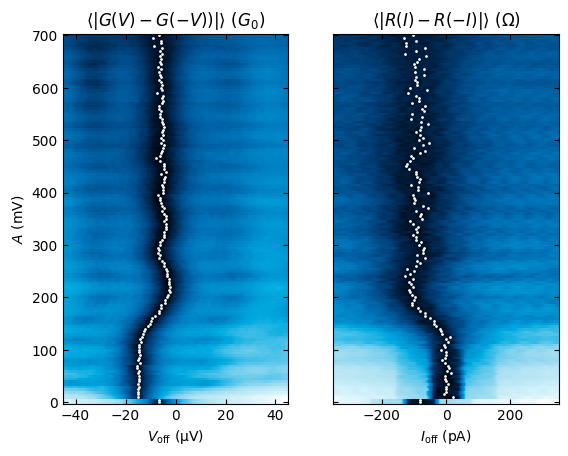

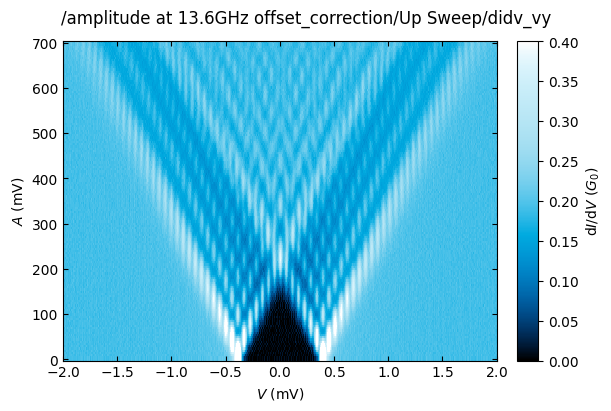

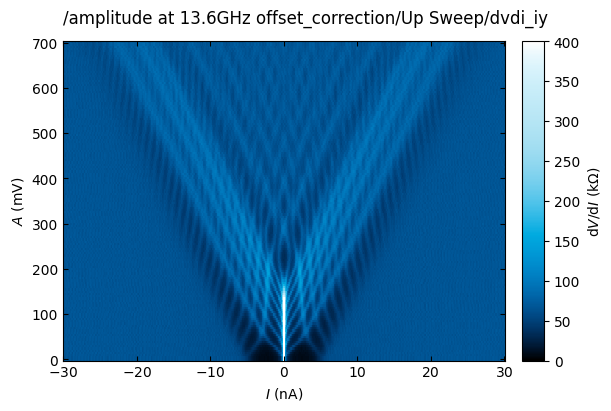

In [36]:
# Offset correction

# region offset definitions
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

def bin_y_over_x_jax(x, y, x_bins):
    """
    1D binning with JAX-safe scatter (no boolean indexing).
    """
    edges = (x_bins[:-1] + x_bins[1:]) / 2
    edges = jnp.concatenate(
        [
            jnp.array([x_bins[0] - (edges[0] - x_bins[0])]),
            edges,
            jnp.array([x_bins[-1] + (x_bins[-1] - edges[-1])]),
        ]
    )

    idx = jnp.digitize(x, edges) - 1  # shape (N,)

    # Clip indices to [0, M-1], out-of-range will produce 0 in sum but count will be 0
    idx_clipped = jnp.clip(idx, 0, x_bins.shape[0] - 1)
    mask = (idx >= 0) & (idx < x_bins.shape[0])
    mask = mask.astype(x.dtype)

    # Sum and count using scatter_add
    sum_y = jnp.zeros(x_bins.shape[0], dtype=y.dtype)
    count = jnp.zeros(x_bins.shape[0], dtype=y.dtype)

    sum_y = sum_y.at[idx_clipped].add(y * mask)
    count = count.at[idx_clipped].add(mask)

    return jnp.where(count > 0, sum_y / count, jnp.nan)


# vectorized over offsets
def bin_y_over_x_offsets(x, y, x_bins, x_off):
    """
    Bin I-V curves shifted by multiple offsets in one call.

    Parameters
    ----------
    x : (N,) x-values
    y : (N,) y_values
    x_bins : (M,) bin centers
    x_off : (K,) offsets

    Returns
    -------
    binned : (M, K) binned currents per offset
    """

    # Define a function for a single offset
    def single_offset_bin(x_shift):
        return bin_y_over_x_jax(x - x_shift, y, x_bins)

    # vmap over all offsets
    binned = jax.vmap(single_offset_bin)(x_off)  # shape (K, M)

    return binned.T  # return shape (M, K)


# endregion

# region initialization
eva = IVEvaluation()
eva.title = f"amplitude at {nu_GHz:.1f}GHz"
eva.sub_folder = ""
eva.loadData()

dV_off_mV = V_off_range_mV[1] - V_off_range_mV[0]
dI_off_nA = I_off_range_nA[1] - I_off_range_nA[0]

A_out_mV: NDArray[np.float64] = np.array(eva.mapped["y_axis"], dtype="float64") * 1e3
dA_out_mV = A_out_mV[1] - A_out_mV[0]
T_exp_K: NDArray[np.float64] = np.array(eva.up_sweep["temperature"], dtype="float64")

dG_err_G0 = np.full((A_out_mV.shape[0], V_off_range_mV.shape[0]), np.nan, dtype="float64")
dR_err_Ohm = np.full((A_out_mV.shape[0], I_off_range_nA.shape[0]), np.nan, dtype="float64")

V_off_mV = np.full((A_out_mV.shape[0]), np.nan, dtype="float64")
I_off_nA = np.full((A_out_mV.shape[0]), np.nan, dtype="float64")

I_exp_nA = np.full((A_out_mV.shape[0], V_mV.shape[0]), np.nan, dtype="float64")
G_exp_G0 = np.full((A_out_mV.shape[0], V_mV.shape[0]), np.nan, dtype="float64")
V_exp_mV = np.full((A_out_mV.shape[0], I_nA.shape[0]), np.nan, dtype="float64")
R_exp_Ohm = np.full((A_out_mV.shape[0], I_nA.shape[0]), np.nan, dtype="float64")
# endregion

# region big loop
for j_a, a_mV in enumerate(tqdm(A_out_mV)):

    v, i = eva.up_sweep["iv_tuples"][j_a][0:2]
    v_mV = np.array(v, dtype="float64") * 1e3
    i_nA = np.array(i, dtype="float64") * 1e9

    v_mV, i_nA = oversample(v_mV, i_nA, upsample=10)

    i_tmp = bin_y_over_x_offsets(v_mV, i_nA, V_mV, V_off_range_mV)
    g_tmp = np.gradient(i_tmp, V_mV, axis=0)
    g_err = np.mean(np.abs(g_tmp - np.flip(g_tmp, axis=0)), axis=0)
    v_off = V_off_range_mV[np.argmin(g_err)]

    v_tmp = bin_y_over_x_offsets(i_nA, v_mV, I_nA, I_off_range_nA)
    r_tmp = np.gradient(v_tmp, I_nA, axis=0)
    r_err = np.mean(np.abs(r_tmp - np.flip(r_tmp, axis=0)), axis=0)
    i_off = I_off_range_nA[np.argmin(r_err)]

    i_exp = bin_y_over_x(v_mV - v_off, i_nA - i_off, V_mV)
    g_exp = np.gradient(i_exp, V_mV) / G_0_muS

    v_exp = bin_y_over_x(i_nA - i_off, v_mV - v_off, I_nA)
    r_exp = np.gradient(v_exp, I_nA) * 1e6

    dG_err_G0[j_a, :] = g_err
    dR_err_Ohm[j_a, :] = r_err

    V_off_mV[j_a] = v_off
    I_off_nA[j_a] = i_off

    I_exp_nA[j_a, :] = i_exp
    G_exp_G0[j_a, :] = g_exp
    V_exp_mV[j_a, :] = v_exp
    R_exp_Ohm[j_a, :] = r_exp
# endregion

# region relocalization
eva.mapped["voltage_axis"] = V_mV * 1e-3
eva.mapped["current_axis"] = I_nA * 1e-9
eva.up_sweep["current"] = I_exp_nA * 1e-9
eva.up_sweep["differential_conductance"] = G_exp_G0
eva.up_sweep["voltage"] = V_exp_mV * 1e-3
eva.up_sweep["differential_resistance"] = R_exp_Ohm
eva.up_sweep["dG_err_G0"] = dG_err_G0
eva.up_sweep["dR_err_Ohm"] = dR_err_Ohm
eva.up_sweep["V_off_mV"] = V_off_mV * 1e-3
eva.up_sweep["I_off_nA"] = I_off_nA * 1e-9


eva.title = f"amplitude at {nu_GHz:.1f}GHz offset_correction"
eva.saveData()
# endregion

# region plot offset errors
fig, [ax_i, ax_v] = plt.subplots(1, 2, num=100, sharey=True)

ax_i.imshow(
    dG_err_G0,
    cmap=cmap(),
    aspect="auto",
    origin="lower",
    interpolation="none",
    extent=(
        (V_off_range_mV[0] - dV_off_mV / 2) * 1e3,
        (V_off_range_mV[-1] + dV_off_mV / 2) * 1e3,
        A_out_mV[0] - dA_out_mV / 2,
        A_out_mV[-1] + dA_out_mV / 2,
    ),
)
ax_i.plot(V_off_mV * 1e3, A_out_mV, ".", color="w", ms=2)

ax_v.imshow(
    dR_err_Ohm,
    cmap=cmap(),
    aspect="auto",
    origin="lower",
    interpolation="none",
    extent=(
        (I_off_range_nA[0] - dI_off_nA / 2) * 1e3,
        (I_off_range_nA[-1] + dI_off_nA / 2) * 1e3,
        A_out_mV[0] - dA_out_mV / 2,
        A_out_mV[-1] + dA_out_mV / 2,
    ),
)
ax_v.plot(I_off_nA * 1e3, A_out_mV, ".", color="w", ms=2)

ax_i.set_ylabel("$A$ (mV)")
ax_i.set_xlabel("$V_\\mathrm{off}$ (µV)")
ax_v.set_xlabel("$I_\\mathrm{off}$ (pA)")


for ax in [ax_i, ax_v]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=True,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )

ax_i.set_title("$\\left\\langle|G(V) - G(-V))|\\right\\rangle$ ($G_0$)")
ax_v.set_title("$\\left\\langle|R(I) - R(-I)|\\right\\rangle$ ($\\Omega$)")
# endregion

# region plot and load offset_corrected data
%matplotlib inline
from utilities.ivplot import IVPlot
importlib.reload(sys.modules["utilities.ivplot"])
logger = logging.getLogger()
logger.setLevel(level=logging.WARNING)

eva = IVPlot()
eva.title = f"amplitude at {nu_GHz:.1f}GHz offset_correction"
eva.sub_folder = ""
eva.loadData()

eva.to_plot = eva.up_sweep
eva.title_of_plot = "Up Sweep"
eva.y_characters = [r"$A$", "V"]
eva.dvdi_norm = (1e3, 'k')
eva.didv_c_lim = (0, 0.4)
eva.dvdi_c_lim = (0, 0.4e6)
if window_length >2:
    eva.smoothing = True
    eva.window_length = window_length
else:
    eva.smoothing = False
eva.plot_T = False
eva.plot_dvdis = True
eva.plot_didvs = True
eva.plot_all()
# endregion

# Model: 'dynes+pat'
# Optimizer: 'curve_fit'

# --- paramters ---
# τ = 0.18899304026099337 (0.0004899600106305177)
# T = 0.008320910186955686 (4.758000550999443) K
# Δ = 0.19604501195187243 (0.003098971515699872) mV
# Γ = 0.004436365952581737 (0.004229175668192533) mV
# A = 0.21395630187199383 (0.010490312829288041) mV
# ν = 13.494956083417806 (1.0883324323806263) GHz

# --- input ---
# solution = fit_current(
#     V_mV=V_mV,
#     I_nA=I_nA,
#     tau = (0.18900, (0.10000, 0.30000), False),
#     T_K = (0.30000, (0.00000, 2.00000), False),
#     Delta_mV = (0.19600, (0.19000, 0.20000), False),
#     Gamma_mV = (0.00400, (0.00010, 0.03000), False),
#     A_mV = (0.21300, (0.00000, 1.00000), False),
#     nu_GHz = (13.60, (12.24, 14.96), False),
#     model="dynes+pat",
#     optimizer="curve_fit",
# )


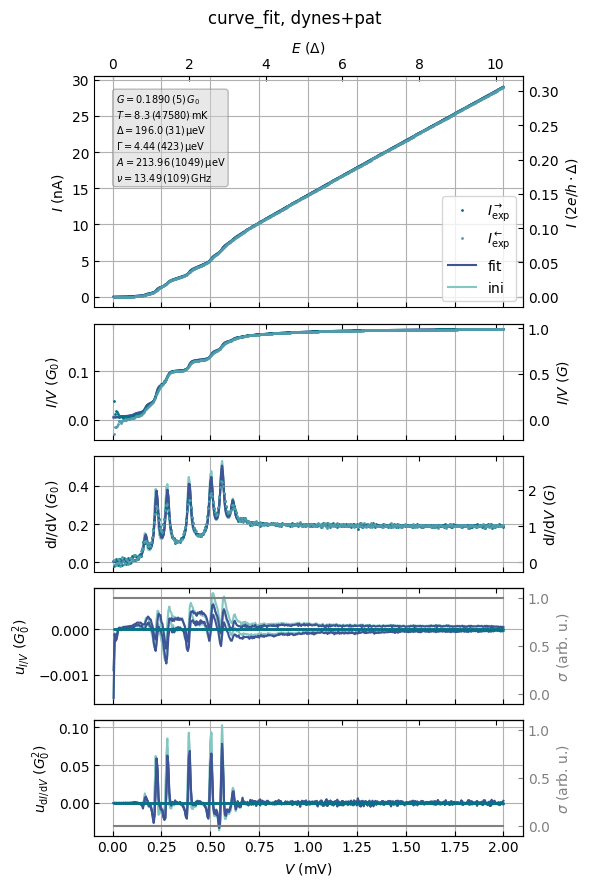

In [22]:
# Test fit one curve
from theory.optimizers.fit_current import fit_current
from theory.optimizers.show_fitting import show_fitting, show_stats

importlib.reload(sys.modules["theory.optimizers.fit_current"])
importlib.reload(sys.modules["theory.optimizers.show_fitting"])

solution = fit_current(
    V_mV=V_mV,
    I_nA=I_exp_nA[20, :],
    tau=(0.189, (0.1, 0.3), False),
    T_K=(0.3, (0, 2), False),
    Delta_mV=(0.196, (0.190, 0.2), False),
    Gamma_mV=(0.004, (1e-4, 30e-3), False),
    A_mV=(0.213, (0, 1), False),
    nu_GHz=(nu_GHz, (nu_GHz * 0.9, nu_GHz * 1.1), False),
    model="dynes+pat",
    optimizer="curve_fit",
)
show_fitting(solution)
show_stats(solution)

In [23]:
# fit the whole thing

from utilities.baseclass import BaseClass

eva = BaseClass()
eva.title = f"amplitude at {nu_GHz:.1f}GHz offset_correction"
eva.sub_folder = ""
eva.loadData()
data = eva.up_sweep | eva.mapped

V_mV = np.array(data["voltage_axis"] * 1e3, dtype="float64")
I_exp_nA = np.array(data["current"] * 1e9, dtype="float64")
tau_0_arbu = tau_0_arbu
T_sample_K = np.array(data["temperature"], dtype="float64")
Delta_0_meV = Delta_0_meV
Gamma_0_meV = Gamma_0_meV
A_out_mV = np.array(data["y_axis"], dtype="float64") * 1e3
nu_GHz = nu_GHz

I_fit_nA = np.full_like(I_exp_nA, np.nan, dtype="float64")
A_fit_mV = np.full_like(A_out_mV, np.nan, dtype="float64")
T_fit_K = np.full_like(T_sample_K, np.nan, dtype="float64")

from theory.optimizers.fit_current import SolutionDict

solutions: list[SolutionDict] = []
for i, _ in enumerate(tqdm(A_out_mV)):
    if i > 1:
        a_mV = A_fit_mV[i - 1]
    else:
        a_mV = 0.0
    solution = fit_current(
        V_mV=V_mV,
        I_nA=I_exp_nA[i, :],
        tau=(tau_0_arbu, (0.1, 0.3), True),
        T_K=(T_sample_K[i], (0, 2), False),
        Delta_mV=(Delta_0_meV, (0.190, 0.2), True),
        Gamma_mV=(Gamma_0_meV, (1e-4, 30e-3), True),
        A_mV=(a_mV, (0, 4), False),
        nu_GHz=(nu_GHz, (nu_GHz * 0.9, nu_GHz * 1.1), True),
        model="dynes+pat",
        optimizer="curve_fit",
    )
    I_fit_nA[i, :] = solution["I_fit_nA"]
    A_fit_mV[i] = solution["A_mV"]
    T_fit_K[i] = solution["T_K"]
    solutions.append(solution)

G_exp_G0 = np.gradient(I_exp_nA, V_mV, axis=1) / G_0_muS
G_fit_G0 = np.gradient(I_fit_nA, V_mV, axis=1) / G_0_muS

100%|██████████| 141/141 [01:49<00:00,  1.28it/s]


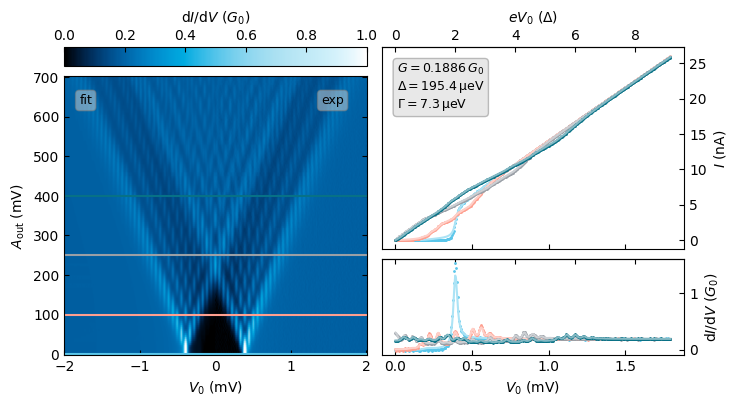

In [31]:
# plot map comparison sim/exp


def VtoE(V_mV):
    return V_mV / Delta_0_meV


def EtoV(E_meV):
    return E_meV * Delta_0_meV


V_label = r"$V_0$ (mV)"
E_label = r"$eV_0$ ($\Delta$)"
I_label = r"$I$ (nA)"
G_label = r"d$I/$d$V$ ($G_0$)"
y_label = r"$A_\mathrm{out}$ (mV)"

index0 = np.argmin(np.abs(V_mV))
index1 = np.argmin(np.abs(V_mV - 1.8))
img_z = np.concatenate((G_fit_G0[:, 1:index0], G_exp_G0[:, index0:]), axis=1)
img_x = V_mV
img_y = A_out_mV

dx, dy = img_x[-1] - img_x[-2], img_y[-1] - img_y[-2]
ext = (img_x[0] - dx / 2, img_x[-1] + dx / 2, img_y[0] - dy / 2, img_y[-1] + dy / 2)
clim = (
    np.nanmean(img_z) - 2 * np.nanstd(img_z),
    np.nanmean(img_z) + 2 * np.nanstd(img_z),
)
clim = (0, 1)

A_indices = []
for A_in in A_interest_mV:
    A_indices.append(np.argmin(np.abs(img_y - A_in)))

# fig and axs
fig, axs = plt.subplots(
    figsize=(8, 4),
    nrows=3,
    ncols=2,
    height_ratios=(0.2, 1.8, 1),
    # sharex = True
)
plt.subplots_adjust(hspace=0.1, wspace=0.05)
ax_clb = axs[0, 0]

gs = axs[0, 1].get_gridspec()
for ax in axs[1:, 0]:
    ax.remove()
ax_img = fig.add_subplot(gs[1:, 0])

gs = axs[1, 0].get_gridspec()
for ax in axs[:2, 1]:
    ax.remove()
ax_i = fig.add_subplot(gs[:2, 1])

ax_g = axs[2, 1]

for ax in [ax_clb, ax_img, ax_i, ax_g]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=False,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )


im = ax_img.imshow(
    img_z,
    aspect="auto",
    origin="lower",
    clim=clim,
    extent=ext,
    interpolation=None,
    cmap=cmap(bad="grey"),
)
# ax_img.vlines(0, ymin=ext[2], ymax=ext[3], color="k")

cbar = fig.colorbar(
    im,
    cax=ax_clb,
    label=G_label,
    orientation="horizontal",
    location="top",
)

ax_img_xlim = ax_img.get_xlim()
for i, A_i in enumerate(A_indices):
    color_exp = colors(i)
    color_fit = colors(i, 0.5)
    ax_i.plot(
        V_mV[index0:index1], I_exp_nA[A_i, index0:index1], ".", ms=2, color=color_exp
    )
    ax_i.plot(V_mV[index0:index1], I_fit_nA[A_i, index0:index1], "-", color=color_fit)
    ax_g.plot(
        V_mV[index0:index1], G_exp_G0[A_i, index0:index1], ".", ms=2, color=color_exp
    )
    ax_g.plot(V_mV[index0:index1], G_fit_G0[A_i, index0:index1], "-", color=color_fit)
    ax_img.plot(ax_img_xlim, (A_out_mV[A_i], A_out_mV[A_i]), color=color_exp)


ax_i_2 = ax_i.secondary_xaxis("top", functions=(VtoE, EtoV))
ax_i_2.tick_params(direction="in", top=True)
ax_g_2 = ax_g.secondary_xaxis("top", functions=(VtoE, EtoV))
ax_g_2.tick_params(direction="in", top=True)

ax_i.xaxis.set_ticklabels([])
ax_g_2.xaxis.set_ticklabels([])

ax_g.yaxis.set_label_position("right")
ax_g.yaxis.tick_right()

ax_i.yaxis.set_label_position("right")
ax_i.yaxis.tick_right()

ax_img.set_ylabel(y_label)
ax_img.set_xlabel(V_label)
ax_g.set_xlabel(V_label)
ax_g.set_ylabel(G_label)
ax_i_2.set_xlabel(E_label)
ax_i.set_ylabel(I_label)

# add text box for the statistics
stats = (
    f"$G={tau_0_arbu:.4f}\\,G_0$\n"
    f"$\\Delta={Delta_0_meV*1e3:.1f}\\,$µeV\n"
    f"$\\Gamma={Gamma_0_meV*1e3:.1f}\\,$µeV"
)
bbox = dict(boxstyle="round", fc="lightgrey", ec="grey", alpha=0.5)
ax_i.text(
    0.05,
    0.7,
    stats,
    fontsize=9,
    bbox=bbox,
    transform=ax_i.transAxes,
    horizontalalignment="left",
)

ax_img.text(0.05, 0.9, "fit", fontsize=9, bbox=bbox, transform=ax_img.transAxes)
ax_img.text(0.85, 0.9, "exp", fontsize=9, bbox=bbox, transform=ax_img.transAxes)

fig.savefig(f"fit_vs_exp_{nu_GHz}GHz.png")

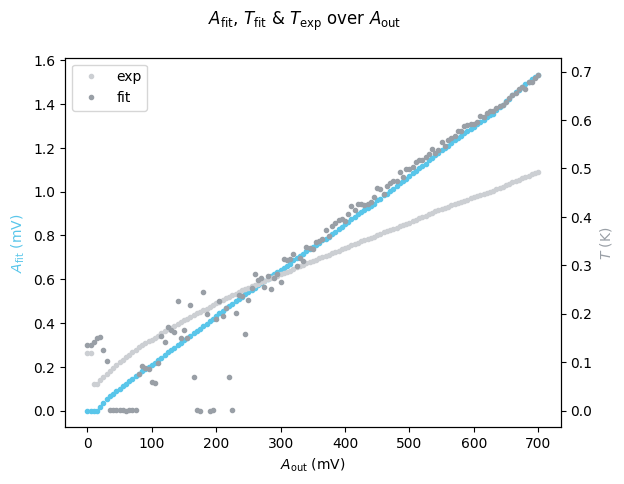

In [ ]:
# show fit parameter
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(A_out_mV, A_fit_mV, ".", color=colors(0))
ax2.plot(A_out_mV, T_exp_K, ".", color=colors(2, 0.5), label="exp")
ax2.plot(A_out_mV, T_fit_K, ".", color=colors(2), label="fit")

ax1.set_xlabel("$A_\\mathrm{out}$ (mV)")
ax1.set_ylabel("$A_\\mathrm{fit}$ (mV)", color=colors(0))
ax2.set_ylabel("$T$ (K)", color=colors(2))

ax2.legend()

fig.suptitle(
    "$A_\\mathrm{fit}$, $T_\\mathrm{fit}$ & $T_\\mathrm{exp}$ over $A_\\mathrm{out}$"
)

plt.show()

(0.0, 1.54)

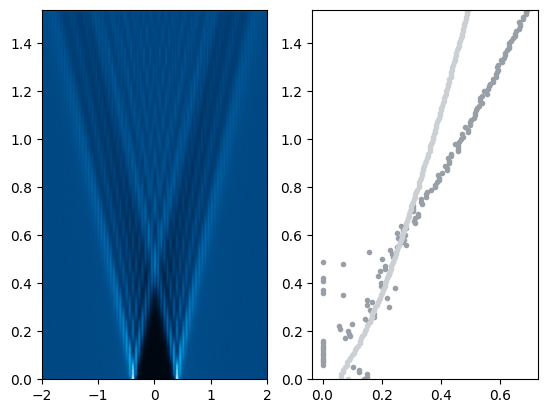

In [ ]:
# bin over A_fit


# region pre-definitions
def bin_z_over_y(y: np.ndarray, z: np.ndarray, y_binned: np.ndarray):
    """
    Bin z-values over y-values using predefined bins.
    If a bin receives no data, fill it from the previous valid bin above (top-down fill).

    Parameters
    ----------
    y : np.ndarray
        Y-values to be binned.
    z : np.ndarray
        Corresponding Z-values (2D array with shape (N, M)).
    y_binned : np.ndarray
        Bin edges for y-values.

    Returns
    -------
    tuple
        Binned z-values (2D), and count of points in each bin.
    """
    number_of_bins = len(y_binned)
    counter = np.zeros(number_of_bins, dtype=int)
    result = np.zeros((number_of_bins, z.shape[1]), dtype=float)

    # Assign y-values to bins
    dig = np.digitize(y, bins=y_binned) - 1
    valid_indices = (dig >= 0) & (dig < number_of_bins)

    # Count entries and sum z-values into bins
    np.add.at(counter, dig[valid_indices], 1)
    np.add.at(result, dig[valid_indices], z[valid_indices])

    # Average values where data exists
    with np.errstate(invalid="ignore"):  # Suppress divide-by-zero warnings
        result[counter > 0] /= counter[counter > 0, None]
        result[counter == 0] = np.nan  # Mark empty bins as NaN
    return result


def fill_nans(arr, mode="both", axis=0):
    """
    Fill NaN values in a 1D or 2D array by propagating values from top/down or averaging both.

    Parameters
    ----------
    arr : np.ndarray
        Input array (1D or 2D) containing NaNs.
    mode : {"top", "down", "both"}, optional
        Direction to fill from:
        - "top": fill NaNs downward (like forward fill)
        - "down": fill NaNs upward (like backward fill)
        - "both": fill NaNs by averaging top & down fills
    axis : int, optional
        If arr is 2D:
        - axis=0 fills along rows (top-down per column)
        - axis=1 fills along columns (left-right per row)

    Returns
    -------
    filled : np.ndarray
        Array with NaNs replaced.
    """
    arr = np.asarray(arr, dtype=float)
    filled = arr.copy()

    if arr.ndim == 1:
        filled = _fill_1d(arr, mode)
    elif arr.ndim == 2:
        if axis == 1:
            filled = np.apply_along_axis(_fill_1d, 1, arr, mode)
        else:
            filled = np.apply_along_axis(_fill_1d, 0, arr, mode)
    else:
        raise ValueError("Only 1D or 2D arrays are supported.")

    return filled


def _fill_1d(vec, mode):
    """Helper: fill a 1D vector with NaNs using top/down/both strategy."""
    v = np.asarray(vec, dtype=float)
    n = len(v)

    # Forward (top) fill
    top = v.copy()
    mask = np.isnan(top)
    idx = np.where(~mask, np.arange(n), 0)
    np.maximum.accumulate(idx, out=idx)
    top[mask] = top[idx[mask]]

    # Backward (down) fill
    down = v.copy()
    mask = np.isnan(down)
    idx = np.where(~mask, np.arange(n), n - 1)
    np.minimum.accumulate(idx[::-1], out=idx[::-1])
    down[mask] = down[idx[mask]]

    if mode == "top":
        return top
    elif mode == "down":
        return down
    elif mode == "both":
        return np.nanmean(np.stack([top, down]), axis=0)
    else:
        raise ValueError("mode must be 'top', 'down', or 'both'")


# endregion

I_binA_nA = bin_z_over_y(A_fit_mV, I_exp_nA, A_mV)
I_binA_nA = fill_nans(I_binA_nA, mode="down", axis=0)
G_binA_G0 = np.gradient(I_binA_nA, V_mV, axis=1) / G_0_muS

T_binA_fit_K = bin_y_over_x(A_fit_mV, T_fit_K, A_mV)
T_binA_fit_K = fill_nans(T_binA_fit_K, mode="down")
T_binA_exp_K = bin_y_over_x(A_fit_mV, T_exp_K, A_mV)
T_binA_exp_K = fill_nans(T_binA_exp_K, mode="down")

# region show binned data
fig, [ax0, ax1] = plt.subplots(1, 2)

ax0.imshow(
    G_binA_G0,
    aspect="auto",
    origin="lower",
    cmap=cmap(),
    extent=(min(V_mV), max(V_mV), min(A_mV), max(A_mV)),
)

ax1.plot(T_binA_fit_K, A_mV, ".", color=colors(2))
ax1.plot(T_binA_exp_K, A_mV, ".", color=colors(2, 0.5))
ax1.set_ylim((min(A_mV), max(A_mV)))
# endregion

array([108.85710995,   9.91289742, 450.01347755])

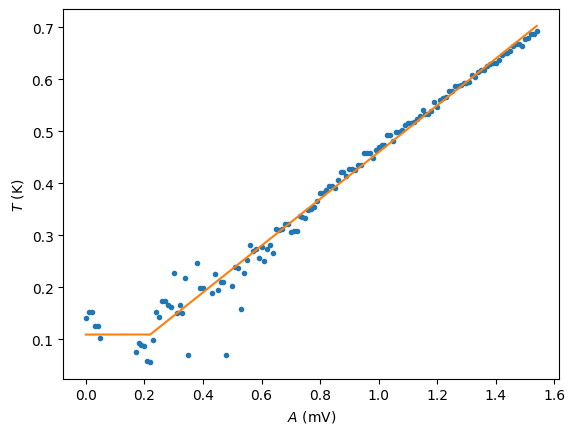

In [ ]:
# fit temperature


def calibration_T(
    x_data: NDArray[np.float64], T_base: float, T_off: float, alpha: float
):
    x_data = T_off + alpha * x_data
    return np.where(x_data <= T_base, T_base, x_data)


# T_base = 311.0 (13) mK
# T_off = -92.2 (21) mK
# alpha = 1.01297 (242)

mask = T_binA_fit_K > 0.05

T_popt, T_pcov = curve_fit(
    f=calibration_T,
    xdata=np.array(A_mV[mask], dtype="float64"),
    ydata=np.array(T_binA_fit_K[mask], dtype="float64"),
)
T_perr = np.sqrt(np.diag(T_pcov))
T_cal_K = calibration_T(A_mV, T_popt[0], T_popt[1], T_popt[2])

plt.plot(A_mV[mask], T_binA_fit_K[mask], ".")
plt.plot(A_mV, T_cal_K)
plt.xlabel("$A$ (mV)")
plt.ylabel("$T$ (K)")
T_popt * 1000

In [92]:
# Simulation
from theory.models.models import get_I_nA
from theory.models.PAT import get_I_pat_nA

I_dynes_nA = get_I_nA(
    V_mV=V_mV,
    tau=tau_0_arbu,
    T_K=T_cal_K,
    Delta_meV=Delta_0_meV,
    Gamma_meV=Gamma_0_meV,
    model="dynes",
)
I_sim_nA = get_I_pat_nA(A_mV=A_mV, V_mV=V_mV, I_nA=I_dynes_nA, nu_GHz=nu_GHz)
G_sim_G0 = np.gradient(I_sim_nA, V_mV, axis=1) / G_0_muS

Dynes: 100%|██████████| 155/155 [00:41<00:00,  3.69it/s]


In [111]:
%matplotlib qt

In [ ]:
# plot map comparison sim/exp


def VtoE(V_mV):
    return V_mV / Delta_0_meV


def EtoV(E_meV):
    return E_meV * Delta_0_meV


V_label = r"$V_0$ (mV)"
E_label = r"$eV_0$ ($\Delta$)"
I_label = r"$I$ (nA)"
G_label = r"d$I/$d$V$ ($G_0$)"
y_label = r"$A$ (mV)"

index0 = np.argmin(np.abs(V_mV))
index1 = np.argmin(np.abs(V_mV - 1.8))
img_z = np.concatenate((G_sim_G0[:, 1:index0], G_binA_G0[:, index0:]), axis=1)
img_x = V_mV
img_y = A_mV

dx, dy = img_x[-1] - img_x[-2], img_y[-1] - img_y[-2]
ext = (img_x[0] - dx / 2, img_x[-1] + dx / 2, img_y[0] - dy / 2, img_y[-1] + dy / 2)
clim = (
    np.nanmean(img_z) - 2 * np.nanstd(img_z),
    np.nanmean(img_z) + 2 * np.nanstd(img_z),
)
clim = (0, 1)

A_indices = []
for A_in in [0, 0.1, 0.5, 1.2]:
    A_indices.append(np.argmin(np.abs(img_y - A_in)))

# fig and axs
fig, axs = plt.subplots(
    figsize=(8, 4),
    nrows=3,
    ncols=2,
    height_ratios=(0.2, 1.8, 1),
    # sharex = True
)
plt.subplots_adjust(hspace=0.1, wspace=0.05)
ax_clb = axs[0, 0]

gs = axs[0, 1].get_gridspec()
for ax in axs[1:, 0]:
    ax.remove()
ax_img = fig.add_subplot(gs[1:, 0])

gs = axs[1, 0].get_gridspec()
for ax in axs[:2, 1]:
    ax.remove()
ax_i = fig.add_subplot(gs[:2, 1])

ax_g = axs[2, 1]

for ax in [ax_clb, ax_img, ax_i, ax_g]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=False,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )


im = ax_img.imshow(
    img_z,
    aspect="auto",
    origin="lower",
    clim=clim,
    extent=ext,
    interpolation=None,
    cmap=cmap(bad="grey"),
)
# ax_img.vlines(0, ymin=ext[2], ymax=ext[3], color="k")

cbar = fig.colorbar(
    im,
    cax=ax_clb,
    label=G_label,
    orientation="horizontal",
    location="top",
)

ax_img_xlim = ax_img.get_xlim()
for i, A_i in enumerate(A_indices):
    color_pos = colors(i)
    color_neg = colors(i, 0.3)
    color_sim = colors(i, 0.5)

    # pos
    ax_i.plot(
        V_mV[index0:index1], I_binA_nA[A_i, index0:index1], ".", ms=2, color=color_pos
    )
    ax_g.plot(
        V_mV[index0:index1], G_binA_G0[A_i, index0:index1], ".", ms=2, color=color_pos
    )

    # neg
    ax_i.plot(
        V_mV[index0:index1],
        -np.flip(I_binA_nA)[A_i, index0:index1],
        ".",
        ms=2,
        color=color_neg,
    )
    ax_g.plot(
        V_mV[index0:index1],
        np.flip(G_binA_G0)[A_i, index0:index1],
        ".",
        ms=2,
        color=color_neg,
    )

    # sim
    ax_i.plot(V_mV[index0:index1], I_sim_nA[A_i, index0:index1], "-", color=color_sim)
    ax_g.plot(V_mV[index0:index1], G_sim_G0[A_i, index0:index1], "-", color=color_sim)

    # img
    ax_img.plot(ax_img_xlim, (img_y[A_i], img_y[A_i]), color=color_pos)


ax_i_2 = ax_i.secondary_xaxis("top", functions=(VtoE, EtoV))
ax_i_2.tick_params(direction="in", top=True)
ax_g_2 = ax_g.secondary_xaxis("top", functions=(VtoE, EtoV))
ax_g_2.tick_params(direction="in", top=True)

ax_i.xaxis.set_ticklabels([])
ax_g_2.xaxis.set_ticklabels([])

ax_g.yaxis.set_label_position("right")
ax_g.yaxis.tick_right()

ax_i.yaxis.set_label_position("right")
ax_i.yaxis.tick_right()

ax_img.set_ylabel(y_label)
ax_img.set_xlabel(V_label)
ax_g.set_xlabel(V_label)
ax_g.set_ylabel(G_label)
ax_i_2.set_xlabel(E_label)
ax_i.set_ylabel(I_label)

# add text box for the statistics
stats = (
    f"$G={tau_0_arbu:.4f}\\,G_0$\n"
    f"$\\Delta={Delta_0_meV*1e3:.1f}\\,$µeV\n"
    f"$\\Gamma={Gamma_0_meV*1e3:.1f}\\,$µeV"
)
bbox = dict(boxstyle="round", fc="lightgrey", ec="grey", alpha=0.5)
ax_i.text(
    0.05,
    0.7,
    stats,
    fontsize=9,
    bbox=bbox,
    transform=ax_i.transAxes,
    horizontalalignment="left",
)

ax_img.text(0.05, 0.9, "sim", fontsize=9, bbox=bbox, transform=ax_img.transAxes)
ax_img.text(0.85, 0.9, "exp", fontsize=9, bbox=bbox, transform=ax_img.transAxes)

fig.savefig(f"sim_vs_exp_{nu_GHz}GHz.png")

# Plotting

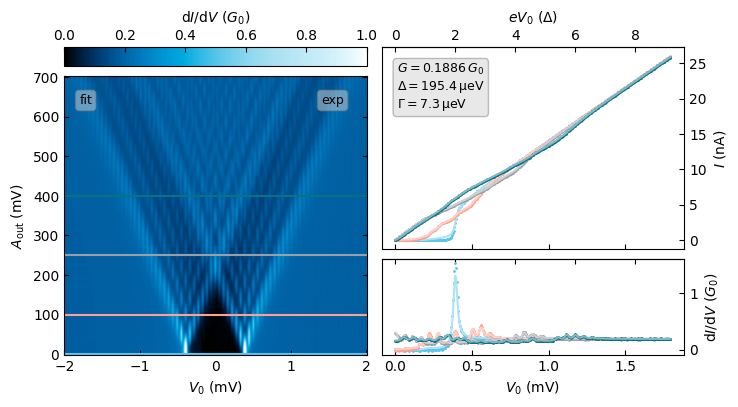

In [51]:
# plot map comparison sim/exp


def VtoE(V_mV):
    return V_mV / Delta_0_meV


def EtoV(E_meV):
    return E_meV * Delta_0_meV


V_label = r"$V_0$ (mV)"
E_label = r"$eV_0$ ($\Delta$)"
I_label = r"$I$ (nA)"
G_label = r"d$I/$d$V$ ($G_0$)"
y_label = r"$A_\mathrm{out}$ (mV)"

index0 = np.argmin(np.abs(V_mV))
index1 = np.argmin(np.abs(V_mV - 1.8))
img_z = np.concatenate((G_fit[:, 1:index0], G_exp[:, index0:]), axis=1)
img_x = V_mV
img_y = A_out_mV

dx, dy = img_x[-1] - img_x[-2], img_y[-1] - img_y[-2]
ext = (img_x[0] - dx / 2, img_x[-1] + dx / 2, img_y[0] - dy / 2, img_y[-1] + dy / 2)
clim = (
    np.nanmean(img_z) - 2 * np.nanstd(img_z),
    np.nanmean(img_z) + 2 * np.nanstd(img_z),
)
clim = (0, 1)

A_indices = []
for A_in in A_interest_mV:
    A_indices.append(np.argmin(np.abs(img_y - A_in)))

# fig and axs
fig, axs = plt.subplots(
    figsize=(8, 4),
    nrows=3,
    ncols=2,
    height_ratios=(0.2, 1.8, 1),
    # sharex = True
)
plt.subplots_adjust(hspace=0.1, wspace=0.05)
ax_clb = axs[0, 0]

gs = axs[0, 1].get_gridspec()
for ax in axs[1:, 0]:
    ax.remove()
ax_img = fig.add_subplot(gs[1:, 0])

gs = axs[1, 0].get_gridspec()
for ax in axs[:2, 1]:
    ax.remove()
ax_i = fig.add_subplot(gs[:2, 1])

ax_g = axs[2, 1]

for ax in [ax_clb, ax_img, ax_i, ax_g]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=False,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )


im = ax_img.imshow(
    img_z,
    aspect="auto",
    origin="lower",
    clim=clim,
    extent=ext,
    interpolation=None,
    cmap=cmap(bad="grey"),
)
# ax_img.vlines(0, ymin=ext[2], ymax=ext[3], color="k")

cbar = fig.colorbar(
    im,
    cax=ax_clb,
    label=G_label,
    orientation="horizontal",
    location="top",
)

ax_img_xlim = ax_img.get_xlim()
for i, A_i in enumerate(A_indices):
    color_exp = colors(i)
    color_fit = colors(i, 0.5)
    ax_i.plot(
        V_mV[index0:index1], I_exp_nA[A_i, index0:index1], ".", ms=2, color=color_exp
    )
    ax_i.plot(V_mV[index0:index1], I_fit_nA[A_i, index0:index1], "-", color=color_fit)
    ax_g.plot(
        V_mV[index0:index1], G_exp[A_i, index0:index1], ".", ms=2, color=color_exp
    )
    ax_g.plot(V_mV[index0:index1], G_fit[A_i, index0:index1], "-", color=color_fit)
    ax_img.plot(ax_img_xlim, (A_out_mV[A_i], A_out_mV[A_i]), color=color_exp)


ax_i_2 = ax_i.secondary_xaxis("top", functions=(VtoE, EtoV))
ax_i_2.tick_params(direction="in", top=True)
ax_g_2 = ax_g.secondary_xaxis("top", functions=(VtoE, EtoV))
ax_g_2.tick_params(direction="in", top=True)

ax_i.xaxis.set_ticklabels([])
ax_g_2.xaxis.set_ticklabels([])

ax_g.yaxis.set_label_position("right")
ax_g.yaxis.tick_right()

ax_i.yaxis.set_label_position("right")
ax_i.yaxis.tick_right()

ax_img.set_ylabel(y_label)
ax_img.set_xlabel(V_label)
ax_g.set_xlabel(V_label)
ax_g.set_ylabel(G_label)
ax_i_2.set_xlabel(E_label)
ax_i.set_ylabel(I_label)

# add text box for the statistics
stats = (
    f"$G={tau_0_arbu:.4f}\\,G_0$\n"
    f"$\\Delta={Delta_0_meV*1e3:.1f}\\,$µeV\n"
    f"$\\Gamma={Gamma_0_meV*1e3:.1f}\\,$µeV"
)
bbox = dict(boxstyle="round", fc="lightgrey", ec="grey", alpha=0.5)
ax_i.text(
    0.05,
    0.7,
    stats,
    fontsize=9,
    bbox=bbox,
    transform=ax_i.transAxes,
    horizontalalignment="left",
)

ax_img.text(0.05, 0.9, "fit", fontsize=9, bbox=bbox, transform=ax_img.transAxes)
ax_img.text(0.85, 0.9, "exp", fontsize=9, bbox=bbox, transform=ax_img.transAxes)

fig.savefig(f"fit_vs_exp_{nu_GHz}GHz.png")

In [ ]:
plt.plot(A_rescaled_mV, T_rescaled_fit_K, ".")

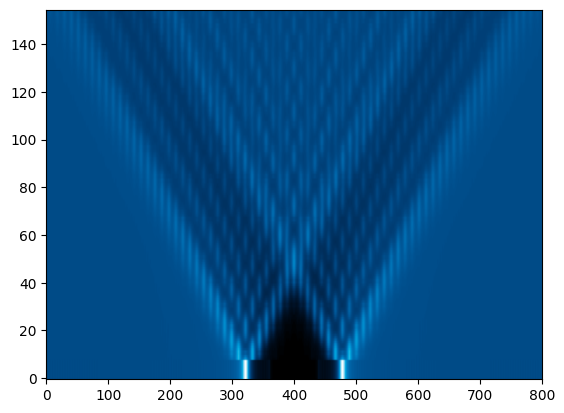

In [17]:
plt.imshow(G_rescaled_fit_G0, aspect="auto", origin="lower", cmap=cmap())

In [16]:
plt.imshow(G_fit, aspect="auto", origin="lower", cmap=cmap())

NameError: name 'G_fit' is not defined

In [67]:
plt.plot(A_out_mV, A_fit_mV, ".")

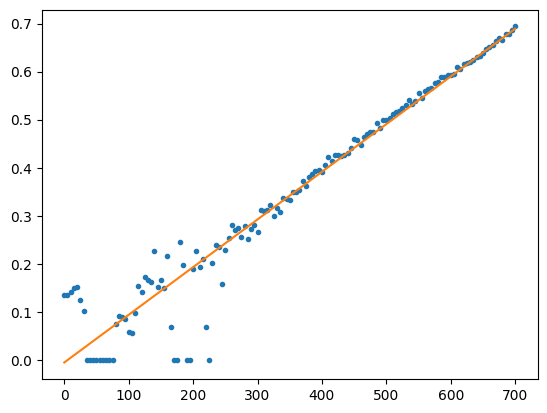

In [ ]:
plt.plot(A_out_mV, T_fit_K, ".")

a, b = np.polyfit(A_out_mV, T_fit_K, 1)

plt.plot(A_out_mV, a * A_out_mV + b)

In [ ]:
plt.figure(0)
plt.imshow(G_rescaled_G0, aspect="auto", origin="lower")
plt.figure(1)
plt.imshow(G_exp_G0, aspect="auto", origin="lower")

In [ ]:
# calculate I_dynes
from theory.models.models import get_I_nA

importlib.reload(sys.modules["theory.models.models"])
I_dynes_raw_nA = get_I_nA(
    V_mV=V_raw_mV,
    tau=tau_0_arbu,
    T_K=T_exp_K * 2.5,
    Delta_meV=Delta_0_meV,
    Gamma_meV=Gamma_0_meV,
    model="dynes",
)

Dynes:   0%|          | 0/142 [00:00<?, ?it/s]

In [36]:
# import theory stuff
importlib.reload(sys.modules["theory.models.PAT"])

from theory.models.PAT import get_I_pat_nA

I_pat_raw_nA = get_I_pat_nA(
    A_mV=A_mV * 1e-3 * 2,
    V_mV=V_raw_mV,
    I_nA=I_dynes_raw_nA,
    nu_GHz=nu_GHz,
    N=N,
)

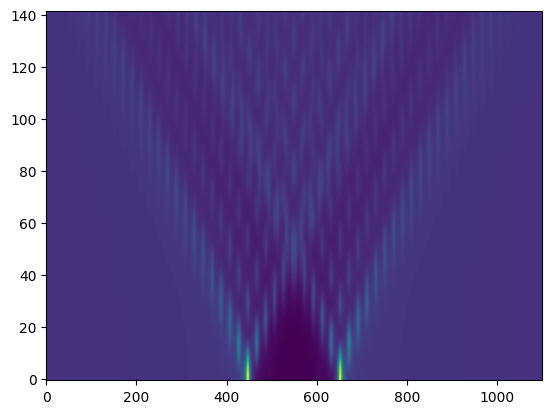

In [37]:
plt.imshow(np.gradient(I_pat_raw_nA, V_raw_mV, axis=1), aspect="auto", origin="lower")

In [ ]:
from theory.optimizers.fit_current import fit_dynes
from theory.optimizers.show_fitting import show_fit_dynes

importlib.reload(sys.modules["theory.optimizers.curve_fit_dynes"])
importlib.reload(sys.modules["theory.optimizers.show_curve_fit_dynes"])

solution = fit_dynes(
    V_mV=V_raw_mV,
    I_nA=I_exp_raw_nA[0, :],
    tau=(0.189, (0.1, 0.3), None),
    T_K=(0.234, (0.1, 2.0), False),
    Delta_mV=(0.196, (0.190, 0.2), True),
    Gamma_mV=(6e-3, (1e-3, 25e-3), False),
)
show_fit_dynes(solution)

ModuleNotFoundError: No module named 'theory'

In [ ]:
I_0_exp_raw_nA = I_exp_raw_nA[0, :]
plt.plot(V_raw_mV, I_0_exp_raw_nA)
plt.plot(V_raw_mV, V_raw_mV * 0.189 * G_0_muS)

In [ ]:
x = V_raw_mV
y = I_0_exp_raw_nA / G_0_muS
w = np.ones_like(x)
w[np.abs(x) < 3 * Delta_0_meV] = 0
a, b = np.polyfit(
    x=x,
    y=y,
    deg=1,
    w=w,
)

In [ ]:
plt.plot(x, y)
plt.plot(x, a * x + b)

In [ ]:
def fit_b_fixed_slope(x, y, a, vcut):
    # mask points far outside gap
    mask = np.abs(x) > vcut
    x_sel = x[mask]
    y_sel = y[mask]
    if x_sel.size == 0:
        raise ValueError("No points outside vcut")

    r = y_sel - a * x_sel  # residuals = b + noise
    b = r.mean()
    return b


b = fit_b_fixed_slope(x, y, a=tau_0_arbu, vcut=3 * Delta_0_meV)
b

np.float64(0.0004057197937035629)

In [ ]:
plt.plot(x, y)
plt.plot(-x, -y)
plt.plot(x, tau_0_arbu * x + b)
plt.plot(x, y + b)
plt.plot(-x, -(y + b))

In [ ]:
# plot map comparison sim/exp
I_theo_nA = I_nA_dynes
G_theo = G_dynes
y = T_K


def VtoE(V_mV):
    return V_mV / Delta_meV


def EtoV(E_meV):
    return E_meV * Delta_meV


V_label = r"$V_0$ (mV)"
E_label = r"$eV_0$ ($\Delta$)"
I_label = r"$I$ (nA)"
G_label = r"d$I/$d$V$ ($G_0$)"
y_label = r"$T$ (K)"

img_z = np.concatenate((np.flip(G_dynes[:, 1:], axis=1), G_exp), axis=1)
img_x = np.concatenate((-np.flip(V_mV[1:]), V_mV), axis=0)
img_y = y

dx, dy = img_x[-1] - img_x[-2], img_y[-1] - img_y[-2]
ext = (img_x[0] - dx / 2, img_x[-1] + dx / 2, img_y[0] - dy / 2, img_y[-1] + dy / 2)
clim = (
    np.nanmean(img_z) - 2 * np.nanstd(img_z),
    np.nanmean(img_z) + 2 * np.nanstd(img_z),
)
clim = (0, 1)

T_indices = []
for T_in in T_interest:
    T_indices.append(np.argmin(np.abs(y - T_in)))

# fig and axs
fig, axs = plt.subplots(
    figsize=(8, 4),
    nrows=3,
    ncols=2,
    height_ratios=(0.2, 1.8, 1),
    # sharex = True
)
plt.subplots_adjust(hspace=0.1, wspace=0.05)
ax_clb = axs[0, 0]

gs = axs[0, 1].get_gridspec()
for ax in axs[1:, 0]:
    ax.remove()
ax_img = fig.add_subplot(gs[1:, 0])

gs = axs[1, 0].get_gridspec()
for ax in axs[:2, 1]:
    ax.remove()
ax_i = fig.add_subplot(gs[:2, 1])

ax_g = axs[2, 1]

for ax in [ax_clb, ax_img, ax_i, ax_g]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=False,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )


im = ax_img.imshow(
    img_z,
    aspect="auto",
    origin="lower",
    clim=clim,
    extent=ext,
    interpolation=None,
    cmap=cmap(bad="grey"),
)
ax_img.vlines(0, ymin=ext[2], ymax=ext[3], color="k")
ax_img.plot(+2 * Delta_T_meV, T_K, "--", color="grey", alpha=0.5)
ax_img.plot(-2 * Delta_T_meV, T_K, "--", color="grey", alpha=0.5)

cbar = fig.colorbar(
    im,
    cax=ax_clb,
    label=G_label,
    orientation="horizontal",
    location="top",
)

ax_img_xlim = ax_img.get_xlim()
for i, T_i in enumerate(T_indices):
    color = colors[i]
    ax_i.plot(V_mV, I_exp_nA[T_i, :], ".", ms=1, color=color)
    ax_i.plot(V_mV, I_theo_nA[T_i, :], "-", color=color)
    ax_g.plot(V_mV, G_exp[T_i, :], ".", ms=1, color=color)
    ax_g.plot(V_mV, G_theo[T_i, :], "-", color=color)
    ax_img.plot(ax_img_xlim, (T_interest[i], T_interest[i]), alpha=0.5, color=color)

ax_i_2 = ax_i.secondary_xaxis("top", functions=(VtoE, EtoV))
ax_i_2.tick_params(direction="in", top=True)
ax_g_2 = ax_g.secondary_xaxis("top", functions=(VtoE, EtoV))
ax_g_2.tick_params(direction="in", top=True)

ax_i.xaxis.set_ticklabels([])
ax_g_2.xaxis.set_ticklabels([])

ax_g.yaxis.set_label_position("right")
ax_g.yaxis.tick_right()

ax_i.yaxis.set_label_position("right")
ax_i.yaxis.tick_right()

ax_img.set_ylabel(y_label)
ax_img.set_xlabel(V_label)
ax_g.set_xlabel(V_label)
ax_g.set_ylabel(G_label)
ax_i_2.set_xlabel(E_label)
ax_i.set_ylabel(I_label)

# add text box for the statistics
stats = (
    f"$G={tau:.4f}\\,G_0$\n"
    f"$\\Delta={Delta_meV*1e3:.1f}\\,$µeV\n"
    f"$\\Gamma={Gamma_meV*1e3:.1f}\\,$µeV"
)
bbox = dict(boxstyle="round", fc="lightgrey", ec="grey", alpha=0.5)
ax_i.text(
    0.05,
    0.7,
    stats,
    fontsize=9,
    bbox=bbox,
    transform=ax_i.transAxes,
    horizontalalignment="left",
)

ax_img.text(0.05, 0.9, "sim", fontsize=9, bbox=bbox, transform=ax_img.transAxes)
ax_img.text(0.85, 0.9, "exp", fontsize=9, bbox=bbox, transform=ax_img.transAxes)

plt.savefig("over_temperature.png")

In [ ]:
# fit parameter
I_0_exp_nA = I_exp_nA[1, :]

p0 = np.array(
    [
        0.18861238619219342,
        0.33346012175065864,
        0.1954362246372233,
        0.0073389200475204005,
    ]
)
bounds = (
    np.array([0.18861, 0.20, 190e-3, 5e-3]),
    np.array([0.18862, 0.35, 200e-3, 25e-3]),
)
maxfev = 10000

In [ ]:
# jax curve fit optimizer for I_0_exp
%reload_ext autoreload
%autoreload 2

import jax.numpy as jnp
from jax import jit, vmap, Array
from jaxfit import CurveFit

from theory.models.dynes_jnp import current, thermal_energy_gap

importlib.reload(sys.modules["theory.models.dynes_jnp"])

G_0_muS_jax = jnp.array(G_0_muS)

@jit
def get_I_nA_optimize(
    V_mV: Array,
    T_K: float,
    Delta_meV: float,
    Gamma_meV: float,
) -> NDArray:
    E_meV: Array = jnp.linspace(-2, 2, 2001)
    current_vectorized = vmap(
        lambda V_mV: current(
            V_meV=V_mV,
            E_meV=E_meV,
            Delta_1_meV=Delta_meV,
            Delta_2_meV=Delta_meV,
            T_K=T_K,
            Gamma_1_meV=Gamma_meV,
            Gamma_2_meV=Gamma_meV,
        ),
        in_axes=0,
    )
    I_nA = current_vectorized(V_mV) * G_0_muS_jax
    return I_nA


def get_I_nA_srapper(x: NDArray, tau:float, T_K:float, Delta_meV:float, Gamma_meV:float) -> NDArray:
    Delta_meV = thermal_energy_gap(Delta_meV=Delta_meV, T_K=T_K)
    I_nA = get_I_nA_optimize(
        V_mV=jnp.array(x, dtype='float64'),
        T_K=T_K,
        Delta_meV=Delta_meV,
        Gamma_meV=Gamma_meV,
    )
    return I_nA * tau

jcf = CurveFit()

popt, pcov = jcf.curve_fit(
    f=get_I_nA_srapper, 
    xdata=np.array(V_mV, dtype='float64'),
    ydata=np.array(I_0_exp_nA, dtype='float64'),
    absolute_sigma=True,
    p0 = p0,
    bounds=bounds,
    maxfev=maxfev,
    )
perr = np.sqrt(np.diag(pcov))

I_theo = get_I_nA_srapper(V_mV, *popt)
I_init = get_I_nA_srapper(V_mV, *p0)

print(f'tau = {popt[0]:.5f} ({int(perr[0]*1e5)})')
print(f'T = {popt[1]*1e3:.1f} ({int(perr[1]*1e4)}) mK')
print(f'Delta = {popt[2]*1e3:.2f} ({int(perr[2]*1e5)}) µeV')
print(f'Gamma = {popt[3]*1e3:.2f} ({int(perr[3]*1e5)}) µeV')

tau = 0.18861 (234)
T = 266.5 (8742) mK
Delta = 194.75 (608) µeV
Gamma = 8.17 (173) µeV


In [ ]:
# get possibilities within bounds
bounds_array = np.array(bounds).T

# Sample n values per parameter
n = 4
param_grid = [np.linspace(lo, hi, n) for lo, hi in bounds_array]

# All combinations
param_sets = list(product(*param_grid))  # shape: (n^4, 4)

I_bounds = np.array([get_I_nA_srapper(V_mV, *params) for params in param_sets])
G_bounds = np.gradient(I_bounds, V_mV, axis=1) / G_0_muS

In [ ]:
# get possibilities within errors
error_array = np.array([popt - perr, popt + perr]).T

# Sample n values per parameter
n = 4
param_grid = [np.linspace(lo, hi, n) for lo, hi in error_array]

# All combinations
param_sets = list(product(*param_grid))  # shape: (n^4, 4)

I_error = np.array([get_I_nA_srapper(V_mV, *params) for params in param_sets])
G_error = np.gradient(I_error, V_mV, axis=1) / G_0_muS

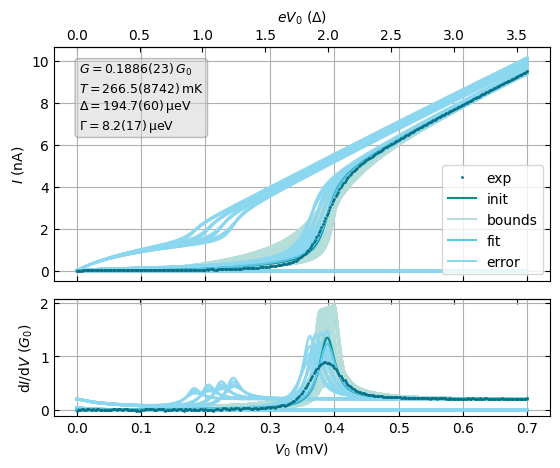

In [ ]:
# show fitting procedure
%matplotlib inline

fig, (ax_i, ax_g) = plt.subplots(ncols=1, nrows=2, sharex=True, height_ratios=(2,1))
plt.subplots_adjust(hspace=0.1, wspace=0.05)

ax_i.plot(V_mV, I_0_exp_nA, '.', label='exp', color=colors[3], ms=2, zorder=13)
ax_g.plot(V_mV, np.gradient(I_0_exp_nA, V_mV)/G_0_muS, '.', color=colors[3], ms=2, zorder=13)

ax_i.plot(V_mV, I_init, label='init', color=colors[4], zorder=11)
ax_g.plot(V_mV, np.gradient(I_init, V_mV)/G_0_muS, color=colors[4], zorder=11)
ax_i.plot(V_mV, I_bounds[0,:], color=lighten_color(colors[4], .7), label='bounds')
for i in range(np.shape(I_bounds)[0]):
    ax_i.plot(V_mV, I_bounds[i,:], color=lighten_color(colors[4], .7))
    ax_g.plot(V_mV, G_bounds[i,:], color=lighten_color(colors[4], .7))

ax_i.plot(V_mV, I_theo, label='fit', color=colors[0], zorder=12)
ax_g.plot(V_mV, np.gradient(I_theo, V_mV)/G_0_muS, color=colors[0], zorder=12)
ax_i.plot(V_mV, I_error[0,:], color=lighten_color(colors[0], .3), label='error')
for i in range(np.shape(I_error)[0]):
    ax_i.plot(V_mV, I_error[i,:], color=lighten_color(colors[0], .3), alpha=.5)
    ax_g.plot(V_mV, G_error[i,:], color=lighten_color(colors[0], .3), alpha=.5)

ax_i.legend(loc='lower right')


for ax in [ax_i, ax_g]:
    ax.tick_params(
            direction='in',       # Ticks nach innen
            top=False,             # obere Ticks ein
            bottom=True,          # untere Ticks ein
            left=True,            # linke Ticks ein
            right=True,           # rechte Ticks ein
            which='both'          # sowohl Major- als auch Minor-Ticks
        )
    ax.grid()

def VtoE(V_mV):
    return V_mV/Delta_meV
def EtoV(E_meV):
    return E_meV*Delta_meV
ax_i_2 = ax_i.secondary_xaxis("top", functions=(VtoE, EtoV))
ax_i_2.tick_params(direction='in', top=True)
ax_g_2 = ax_g.secondary_xaxis("top", functions=(VtoE, EtoV))
ax_g_2.tick_params(direction='in', top=True)

ax_g_2.xaxis.set_ticklabels([])

ax_g.set_xlabel(V_label)
ax_g.set_ylabel(G_label)
ax_i_2.set_xlabel(E_label)
ax_i.set_ylabel(I_label)

# add text box for the statistics
stats = (f'$G={popt[0]:.4f} ({int(perr[0]*1e4)})\\,G_0$\n'
         f'$T={popt[1]*1e3:.1f} ({int(perr[1]*1e4)})\\,$mK\n'
        f'$\\Delta={popt[2]*1e3:.1f} ({int(perr[2]*1e4)})\\,$µeV\n'
        f'$\\Gamma={popt[3]*1e3:.1f} ({int(perr[3]*1e4)})\\,$µeV')
bbox = dict(boxstyle='round', fc='lightgrey', ec='grey', alpha=0.5)
ax_i.text(0.05, .65, stats, fontsize=9, bbox=bbox,
        transform=ax_i.transAxes, horizontalalignment='left')
fig.savefig('fitting_procedure.png')

In [ ]:
# jax curve fit over I over T_K
%reload_ext autoreload
%autoreload 2


def fixed_I_nA(x: NDArray, T_K:float):
    tau = 0.18835012
    Delta_meV = 0.19524671
    Gamma_meV = 0.00823909
    return get_I_nA_srapper(x, tau, T_K, Delta_meV, Gamma_meV)

jcf = CurveFit()

T_fit_K = np.zeros_like(T_K)
dT_fit_K = np.zeros_like(T_K)
for i, I_0_nA in enumerate(tqdm(I_exp_nA)):
    popt, pcov = jcf.curve_fit(
        f=fixed_I_nA, 
        xdata=np.array(V_mV, dtype='float64'),
        ydata=np.array(I_0_nA, dtype='float64'),
        p0 = T_K[i],
        )
    T_fit_K[i] = popt[0]
    
    perr = np.sqrt(np.diag(pcov))
    dT_fit_K[i] = perr[0]

100%|██████████| 241/241 [01:03<00:00,  3.82it/s]


In [ ]:
# calibrate T_K with curve_fit
T_theo_K = np.copy(T_fit_K)

T_exp_K = T_K[T_theo_K <= 2]
T_theo_K = T_theo_K[T_theo_K <= 2]


def calibration_T(T: NDArray, T_base: float, T_off: float, alpha: float):
    T = T_off + alpha * T
    return np.where(T <= T_base, T_base, T)


T_popt, T_pcov = curve_fit(
    f=calibration_T,
    xdata=np.array(T_exp_K, dtype="float64"),
    ydata=np.array(T_theo_K, dtype="float64"),
)
T_perr = np.sqrt(np.diag(T_pcov))
T_cal_K = calibration_T(T_exp_K, T_popt[0], T_popt[1], T_popt[2])
T_popt, T_perr

print(f"T_base = {T_popt[0]*1e3:.1f} ({int(T_perr[0]*1e4)}) mK")
print(f"T_off = {T_popt[1]*1e3:.1f} ({int(T_perr[1]*1e4)}) mK")
print(f"alpha = {T_popt[2]:.5f} ({int(T_perr[2]*1e5)})")

T_base = 311.0 (13) mK
T_off = -92.2 (21) mK
alpha = 1.01297 (242)


In [ ]:
# get possibilities within errors
T_error_array = np.array([T_popt - T_perr, T_popt + T_perr]).T

# Sample n values per parameter
n = 4
param_grid = [np.linspace(lo, hi, n) for lo, hi in T_error_array]

# All combinations
param_sets = list(product(*param_grid))  # shape: (n^4, 4)

T_err_K = np.array([calibration_T(T_exp_K, *params) for params in param_sets])

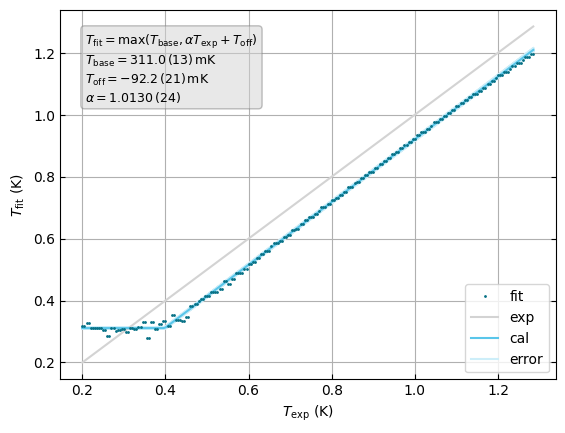

In [ ]:
# show calibration procedure
%matplotlib inline

fig, (ax_T) = plt.subplots()

ax_T.plot(T_exp_K, T_theo_K, '.', label='fit', color=colors[3], ms=2, zorder=13)
ax_T.plot(T_exp_K, T_exp_K, label='exp', color='lightgrey', zorder=11)
ax_T.plot(T_exp_K, T_cal_K, label="cal", color=colors[0], zorder=12)
ax_T.plot(T_exp_K, T_err_K[0,:], color=lighten_color(colors[0], .7), label="error", zorder=10)
ax_T.plot(T_exp_K, T_err_K.T, color=lighten_color(colors[0], .7), zorder=10)

ax_T.tick_params(
        direction='in',       # Ticks nach innen
        top=False,             # obere Ticks ein
        bottom=True,          # untere Ticks ein
        left=True,            # linke Ticks ein
        right=True,           # rechte Ticks ein
        which='both'          # sowohl Major- als auch Minor-Ticks
    )

ax_T.grid()
ax_T.legend()
ax_T.set_xlabel('$T_\\mathrm{exp}$ (K)')
ax_T.set_ylabel('$T_\\mathrm{fit}$ (K)')


# add text box for the statistics
stats = ('$T_\\mathrm{fit} = \\mathrm{max}(T_\\mathrm{base}, \\alpha T_\\mathrm{exp}+T_\\mathrm{off})$ \n'
    '$T_\\mathrm{base}$'
    f'$={T_popt[0]*1e3:.1f}\\,({int(T_perr[0]*1e4)})\\,$mK\n'
         '$T_\\mathrm{off} = $'
         f'${T_popt[1]*1e3:.1f}\\,({int(T_perr[1]*1e4)})\\,$mK\n'
        f'$\\alpha={T_popt[2]:.4f}\\,({int(T_perr[2]*1e4)})\\,$')
bbox = dict(boxstyle='round', fc='lightgrey', ec='grey', alpha=0.5)
ax_T.text(0.05, .75, stats, fontsize=9, bbox=bbox,
        transform=ax_T.transAxes, horizontalalignment='left')
plt.savefig('temperature_model.png')

In [ ]:
# calibration data
T_base: float = 0.25828968
T_off: float = -0.12844258
alpha: float = 1.04900186

# fit parameter
tau: float = 0.18835012
Delta_meV: float = 0.19524671
Gamma_meV: float = 0.00823908

In [ ]:
# # plot comparison (sim input is T_fit)
# I_nA_dynes = get_I_nA(
#     V_mV = V_mV,
#     tau=tau,
#     T_K=T_fit_K,
#     Delta_meV=Delta_meV,
#     Gamma_meV=Gamma_meV,
#     model='dynes',
#     )
# G_dynes = np.gradient(I_nA_dynes, V_mV, axis=-1) / G_0_muS

# V_mV = V_mV
# Delta_meV = Delta_meV
# I_exp_nA = I_exp_nA
# G_exp = G_exp
# I_theo_nA = I_nA_dynes
# G_theo = G_dynes
# y = T_K

# # plot map comparison sim/exp

# def VtoE(V_mV): return V_mV / Delta_meV
# def EtoV(E_meV): return E_meV * Delta_meV

# V_label=r'$V_0$ (mV)'
# E_label=r'$eV_0$ ($\Delta$)'
# I_label=r'$I$ (nA)'
# G_label=r'd$I/$d$V$ ($G_0$)'
# y_label=r'$T^*$ (K)'

# img_z = np.concatenate((np.flip(G_dynes[:,1:], axis=1), G_exp), axis=1)
# img_x = np.concatenate((-np.flip(V_mV[1:]), V_mV), axis=0)
# img_y = y

# dx, dy = img_x[-1]-img_x[-2], img_y[-1]-img_y[-2]
# ext = (img_x[0]-dx/2, img_x[-1]+dx/2, img_y[0]-dy/2, img_y[-1]+dy/2)
# clim = (np.nanmean(img_z)-2*np.nanstd(img_z), np.nanmean(img_z)+2*np.nanstd(img_z))
# clim = (0, 1)

# T_indices = []
# for T_in in T_interest:
#     T_indices.append(np.argmin(np.abs(y-T_in)))

# # fig and axs
# fig, axs = plt.subplots(
#     figsize=(8,4),
#     nrows=3,
#     ncols=2,
#     height_ratios=(0.2, 1.8, 1),
#     # sharex = True
#     )
# plt.subplots_adjust(hspace=0.1, wspace=0.05)
# ax_clb = axs[0,0]

# gs = axs[0, 1].get_gridspec()
# for ax in axs[1:, 0]:
#     ax.remove()
# ax_img = fig.add_subplot(gs[1:, 0])

# gs = axs[1,0].get_gridspec()
# for ax in axs[:2, 1]:
#     ax.remove()
# ax_i = fig.add_subplot(gs[:2, 1])

# ax_g = axs[2,1]

# for ax in [ax_clb,ax_img, ax_i, ax_g]:
#     ax.tick_params(
#             direction='in',       # Ticks nach innen
#             top=False,             # obere Ticks ein
#             bottom=True,          # untere Ticks ein
#             left=True,            # linke Ticks ein
#             right=True,           # rechte Ticks ein
#             which='both'          # sowohl Major- als auch Minor-Ticks
#         )


# im = ax_img.imshow(
#     img_z,
#     aspect='auto',
#     origin='lower',
#     clim=clim,
#     extent=ext,
#     interpolation=None,
#     cmap=cmap(bad="grey"),
#     )
# ax_img.vlines(0, ymin=ext[2], ymax=ext[3], color='k')

# cbar = fig.colorbar(
#     im,
#     cax=ax_clb,
#     label=G_label,
#     orientation='horizontal',
#     location='top',
#     )

# ax_img_xlim = ax_img.get_xlim()
# for i, T_i in enumerate(T_indices):
#     color=colors[i]
#     ax_i.plot(V_mV, I_exp_nA[T_i,:], '.', ms=1, color=color)
#     ax_i.plot(V_mV, I_theo_nA[T_i,:], '-', color=color)
#     ax_g.plot(V_mV, G_exp[T_i,:], '.', ms=1, color=color)
#     ax_g.plot(V_mV, G_theo[T_i,:], '-', color=color)
#     ax_img.plot(ax_img_xlim, (T_interest[i], T_interest[i]), alpha=.5, color=color)

# ax_i_2 = ax_i.secondary_xaxis("top", functions=(VtoE, EtoV))
# ax_i_2.tick_params(direction='in', top=True)
# ax_g_2 = ax_g.secondary_xaxis("top", functions=(VtoE, EtoV))
# ax_g_2.tick_params(direction='in', top=True)

# ax_i.xaxis.set_ticklabels([])
# ax_g_2.xaxis.set_ticklabels([])

# ax_g.yaxis.set_label_position("right")
# ax_g.yaxis.tick_right()

# ax_i.yaxis.set_label_position("right")
# ax_i.yaxis.tick_right()

# ax_img.set_ylabel(y_label)
# ax_img.set_xlabel(V_label)
# ax_g.set_xlabel(V_label)
# ax_g.set_ylabel(G_label)
# ax_i_2.set_xlabel(E_label)
# ax_i.set_ylabel(I_label)

# # add text box for the statistics
# stats = (f'$G={tau:.4f}\\,G_0$\n'
#         f'$\\Delta={Delta_meV*1e3:.1f}\\,$µeV\n'
#         f'$\\Gamma={Gamma_meV*1e3:.1f}\\,$µeV')
# bbox = dict(boxstyle='round', fc='lightgrey', ec='grey', alpha=0.5)
# ax_i.text(0.05, .7, stats, fontsize=9, bbox=bbox,
#         transform=ax_i.transAxes, horizontalalignment='left')

# ax_img.text(.05, .9, "sim*", fontsize=9, bbox=bbox, transform=ax_img.transAxes)
# ax_img.text(.85, .9, "exp", fontsize=9, bbox=bbox, transform=ax_img.transAxes)

In [ ]:
# Get calibrated exp data
from utilities.ivplot import IVPlot

importlib.reload(sys.modules["utilities.ivplot"])
logger = logging.getLogger()
logger.setLevel(level=logging.WARNING)

eva = IVPlot()
eva.file_directory = "/Users/oliver/Documents/measurement data/"
eva.file_folder = "25 04 OI-25c-09/unbroken/"
eva.file_name = "OI-25c-09 2025-04-15 unbroken 1.hdf5"
eva.title = "temperature study (calibrated)"
eva.sub_folder = ""

eva.setAmplifications(1000, 1000)
eva.setV(voltage_minimum=-0.1e-3, voltage_maximum=0.8e-3, voltage_bins=450)
eva.setI(current_minimum=-0.1e-8, current_maximum=0.8e-8, current_bins=450)
eva.setT(0.2, 1.4, 240)
eva.downsample_frequency = 137

eva.showMeasurements()

eva.setMeasurement("temperatures")
eva.showKeys()
eva.setKeys(index_0=7, index_1=-3, norm=1e-6, to_pop="no_heater")
(eva.up_sweep,) = eva.getMaps([1])


def calibration_T(T: NDArray, T_base: float, T_off: float, alpha: float):
    T = T_off + alpha * T
    return np.where(T <= T_base, T_base, T)


eva.up_sweep["temperature"] = calibration_T(
    T=eva.up_sweep["temperature"],
    T_base=T_base,
    T_off=T_off,
    alpha=alpha,
)

(eva.up_sweep,) = eva.getMapsTemperature([eva.up_sweep])
eva.y_axis = eva.temperature_axis
eva.saveData()

100%|██████████| 150/150 [01:27<00:00,  1.71it/s]


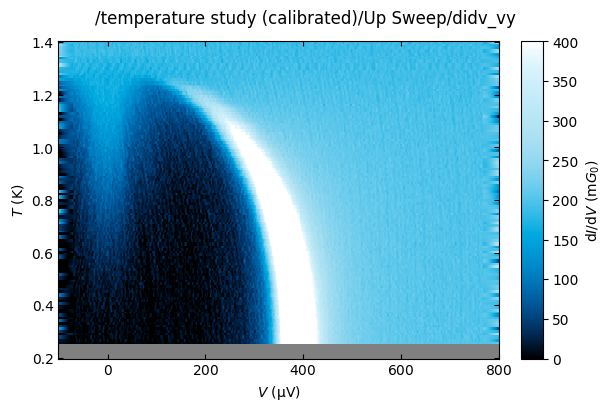

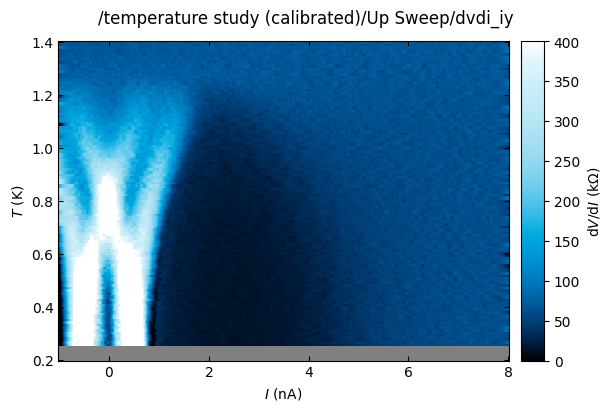

In [ ]:
# load and show calibrated exp data
%matplotlib inline

from utilities.ivplot import IVPlot
importlib.reload(sys.modules["utilities.ivplot"])
logger = logging.getLogger()
logger.setLevel(level=logging.WARNING)

eva = IVPlot()
eva.title = "temperature study (calibrated)"
eva.sub_folder = ""

eva.loadData()
eva.to_plot = eva.up_sweep
eva.title_of_plot = "Up Sweep"
eva.y_characters = [r"$T$", "K"]
eva.dvdi_norm = (1e3, 'k')
eva.didv_c_lim = (0, 0.4)
eva.dvdi_c_lim = (0, 0.4e6)
eva.smoothing = True
eva.window_length = 30
eva.plot_T = False
eva.plot_all()

In [ ]:
# Recalculate calibrated exp data
T_cal_K: NDArray = eva.mapped["temperature_axis"]
V_mV: NDArray = np.linspace(0, 0.7, 351)

V_mV_raw: NDArray = eva.mapped["voltage_axis"] * 1e3
I_exp_nA_raw: NDArray = eva.up_sweep["current"] * 1e9
G_exp_raw: NDArray = eva.up_sweep["differential_conductance"]

I_exp_nA_raw = savgol_filter(I_exp_nA_raw, 30, 2)
G_exp_raw = savgol_filter(G_exp_raw, 30, 2)

I_exp_nA = np.zeros((T_cal_K.shape[0], V_mV.shape[0]))
G_exp = np.zeros((T_cal_K.shape[0], V_mV.shape[0]))
for i, t in enumerate(T_cal_K):
    I_exp_nA[i, :] = bin_y_over_x(V_mV_raw, I_exp_nA_raw[i, :], V_mV)
    G_exp[i, :] = bin_y_over_x(V_mV_raw, G_exp_raw[i, :], V_mV)

from theory.models.dynes_jnp import thermal_energy_gap

Delta_T_meV: NDArray = np.array(thermal_energy_gap(Delta_meV=Delta_meV, T_K=T_cal_K))
Delta_T_meV[Delta_T_meV == 0.0] = np.nan

T_interest: NDArray = np.array([0.3, 0.8, 1, 1.1, 1.2, 1.25])

In [ ]:
# get dynes for calibrated T
I_dynes_nA: NDArray = get_I_nA(
    V_mV=V_mV,
    tau=tau,
    T_K=T_cal_K,
    Delta_meV=Delta_meV,
    Gamma_meV=Gamma_meV,
    model="dynes",
)
G_dynes: NDArray = np.gradient(I_dynes_nA, V_mV, axis=-1) / G_0_muS

Dynes: 100%|██████████| 241/241 [00:44<00:00,  5.46it/s]


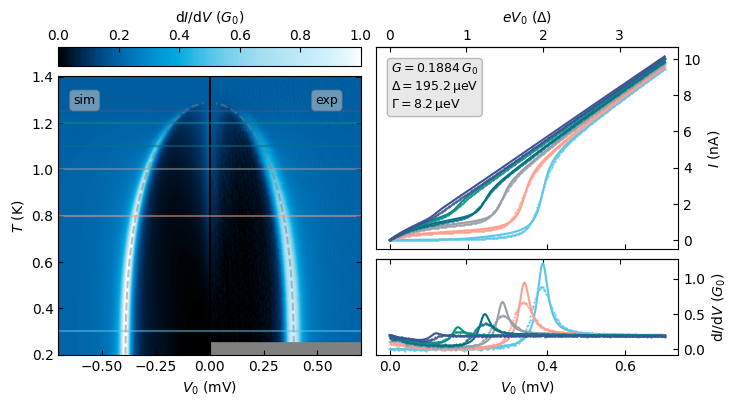

In [ ]:
# plot map comparison sim/exp

T = T_cal_K


def VtoE(V_mV):
    return V_mV / Delta_meV


def EtoV(E_meV):
    return E_meV * Delta_meV


V_label = r"$V_0$ (mV)"
E_label = r"$eV_0$ ($\Delta$)"
I_label = r"$I$ (nA)"
G_label = r"d$I/$d$V$ ($G_0$)"
y_label = r"$T$ (K)"

img_z = np.concatenate((np.flip(G_dynes[:, 1:], axis=1), G_exp), axis=1)
img_x = np.concatenate((-np.flip(V_mV[1:]), V_mV), axis=0)
img_y = T

dx, dy = img_x[-1] - img_x[-2], img_y[-1] - img_y[-2]
ext = (img_x[0] - dx / 2, img_x[-1] + dx / 2, img_y[0] - dy / 2, img_y[-1] + dy / 2)
clim = (
    np.nanmean(img_z) - 2 * np.nanstd(img_z),
    np.nanmean(img_z) + 2 * np.nanstd(img_z),
)
clim = (0, 1)

T_indices = []
for T_in in T_interest:
    T_indices.append(np.argmin(np.abs(T - T_in)))

# fig and axs
fig, axs = plt.subplots(
    figsize=(8, 4),
    nrows=3,
    ncols=2,
    height_ratios=(0.2, 1.8, 1),
    # sharex = True
)
plt.subplots_adjust(hspace=0.1, wspace=0.05)
ax_clb = axs[0, 0]

gs = axs[0, 1].get_gridspec()
for ax in axs[1:, 0]:
    ax.remove()
ax_img = fig.add_subplot(gs[1:, 0])

gs = axs[1, 0].get_gridspec()
for ax in axs[:2, 1]:
    ax.remove()
ax_i = fig.add_subplot(gs[:2, 1])

ax_g = axs[2, 1]

for ax in [ax_clb, ax_img, ax_i, ax_g]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=False,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )


im = ax_img.imshow(
    img_z,
    aspect="auto",
    origin="lower",
    clim=clim,
    extent=ext,
    interpolation=None,
    cmap=cmap(bad="grey"),
)
ax_img.vlines(0, ymin=ext[2], ymax=ext[3], color="k")
ax_img.plot(+2 * Delta_T_meV, T_cal_K, "--", color="grey", alpha=0.5)
ax_img.plot(-2 * Delta_T_meV, T_cal_K, "--", color="grey", alpha=0.5)

cbar = fig.colorbar(
    im,
    cax=ax_clb,
    label=G_label,
    orientation="horizontal",
    location="top",
)

ax_img_xlim = ax_img.get_xlim()
for i, T_i in enumerate(T_indices):
    color = colors[i]
    ax_i.plot(V_mV, I_exp_nA[T_i, :], ".", ms=1, color=color)
    ax_i.plot(V_mV, I_dynes_nA[T_i, :], "-", color=color)
    ax_g.plot(V_mV, G_exp[T_i, :], ".", ms=1, color=color)
    ax_g.plot(V_mV, G_dynes[T_i, :], "-", color=color)
    ax_img.plot(ax_img_xlim, (T_interest[i], T_interest[i]), alpha=0.5, color=color)


ax_i_2 = ax_i.secondary_xaxis("top", functions=(VtoE, EtoV))
ax_i_2.tick_params(direction="in", top=True)
ax_g_2 = ax_g.secondary_xaxis("top", functions=(VtoE, EtoV))
ax_g_2.tick_params(direction="in", top=True)

ax_i.xaxis.set_ticklabels([])
ax_g_2.xaxis.set_ticklabels([])

ax_g.yaxis.set_label_position("right")
ax_g.yaxis.tick_right()

ax_i.yaxis.set_label_position("right")
ax_i.yaxis.tick_right()

ax_img.set_ylabel(y_label)
ax_img.set_xlabel(V_label)
ax_g.set_xlabel(V_label)
ax_g.set_ylabel(G_label)
ax_i_2.set_xlabel(E_label)
ax_i.set_ylabel(I_label)

# add text box for the statistics
stats = (
    f"$G={tau:.4f}\\,G_0$\n"
    f"$\\Delta={Delta_meV*1e3:.1f}\\,$µeV\n"
    f"$\\Gamma={Gamma_meV*1e3:.1f}\\,$µeV"
)
bbox = dict(boxstyle="round", fc="lightgrey", ec="grey", alpha=0.5)
ax_i.text(
    0.05,
    0.7,
    stats,
    fontsize=9,
    bbox=bbox,
    transform=ax_i.transAxes,
    horizontalalignment="left",
)

ax_img.text(0.05, 0.9, "sim", fontsize=9, bbox=bbox, transform=ax_img.transAxes)
ax_img.text(0.85, 0.9, "exp", fontsize=9, bbox=bbox, transform=ax_img.transAxes)

fig.savefig("over_calibrated_T.png")